# Install SLEAP
Don't forget to set **Runtime** -> **Change runtime type...** -> **GPU** as the accelerator.

In [ ]:
!pip install sleap -qqq
!pip install albumentations -qqq
!pip install nvidia-ml-py3 -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.1/904.1 kB 69.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 23.3 MB/s eta 0:0

In [ ]:
import os
import gc
import random
import math
import time
import collections
from typing import Sequence, Tuple, Text, Union, Optional, List

import nvidia_smi

import numpy as np
import albumentations as A

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import sleap

sleap.versions()

SLEAP: 1.3.1
TensorFlow: 2.8.4
Numpy: 1.22.4
Python: 3.10.12
OS: Linux-5.15.107+-x86_64-with-glibc2.31


# Utils

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def get_vram():
    nvidia_smi.nvmlInit()

    deviceCount = nvidia_smi.nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
        info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        output = ("Device {}: {}, Memory : ({:.2f}% free): {} (total), {} (free), {} (used)"
              .format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total,
                      info.total/(1024 ** 3), info.free/(1024 ** 3), info.used/(1024 ** 3)))

    nvidia_smi.nvmlShutdown()

    return output

def get_param_count(model):
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  total_params = sum(p.numel() for p in model.parameters())
  nontrainable_params = total_params - trainable_params

  return trainable_params, nontrainable_params, total_params

In [ ]:
seed = 42
seed_everything(seed)

# Download training data

In [ ]:
!curl -L --output labels.slp https://storage.googleapis.com/sleap-data/datasets/wt_gold.13pt/tracking_split2/train.pkg.slp
!ls -lah

!curl -L --output val_labels.slp https://storage.googleapis.com/sleap-data/datasets/wt_gold.13pt/tracking_split2/val.pkg.slp
!ls -lah

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  619M  100  619M    0     0  33.1M      0  0:00:18  0:00:18 --:--:-- 39.0M
total 620M
drwxr-xr-x 1 root root 4.0K Jun 25 02:58 .
drwxr-xr-x 1 root root 4.0K Jun 25 02:49 ..
drwxr-xr-x 4 root root 4.0K Jun 23 01:14 .config
-rw-r--r-- 1 root root 620M Jun 25 02:58 labels.slp
drwxr-xr-x 1 root root 4.0K Jun 23 01:15 sample_data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77.2M  100 77.2M    0     0  19.6M      0  0:00:03  0:00:03 --:--:-- 19.6M
total 697M
drwxr-xr-x 1 root root 4.0K Jun 25 02:58 .
drwxr-xr-x 1 root root 4.0K Jun 25 02:49 ..
drwxr-xr-x 4 root root 4.0K Jun 23 01:14 .config
-rw-r--r-- 1 root root 620M Jun 25 02:58 labels.slp
drwxr-xr-x 1 root root 4.0K Jun 23 01:15 sample_data
-rw-r--r-- 1 root root

# Load the training data

In [ ]:
# SLEAP Labels files (.slp) can include the images as well as labeled instances and
# other metadata for a project.
labels = sleap.load_file("labels.slp")
labels = labels.with_user_labels_only()
labels.describe()

Skeleton: Skeleton(description=None, nodes=[head, thorax, abdomen, wingL, wingR, forelegL4, forelegR4, midlegL4, midlegR4, hindlegL4, hindlegR4, eyeL, eyeR], edges=[thorax->head, thorax->abdomen, thorax->wingL, thorax->wingR, thorax->forelegL4, thorax->forelegR4, thorax->midlegL4, thorax->midlegR4, thorax->hindlegL4, thorax->hindlegR4, head->eyeL, head->eyeR], symmetries=[forelegL4<->forelegR4, hindlegL4<->hindlegR4, wingL<->wingR, eyeL<->eyeR, midlegL4<->midlegR4])
Videos: ['labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp', 'labels.slp']
Frames (user/predicted): 1,600/0
Instances (user/predicted): 3,200/0
Tracks: [Track(spawned_on=0, na

In [ ]:
# Let's also do the same for the val labels.
val_labels = sleap.load_file("val_labels.slp")
val_labels = val_labels.with_user_labels_only()
val_labels.describe()

Skeleton: Skeleton(description=None, nodes=[head, thorax, abdomen, wingL, wingR, forelegL4, forelegR4, midlegL4, midlegR4, hindlegL4, hindlegR4, eyeL, eyeR], edges=[thorax->head, thorax->abdomen, thorax->wingL, thorax->wingR, thorax->forelegL4, thorax->forelegR4, thorax->midlegL4, thorax->midlegR4, thorax->hindlegL4, thorax->hindlegR4, head->eyeL, head->eyeR], symmetries=[hindlegL4<->hindlegR4, midlegL4<->midlegR4, eyeL<->eyeR, wingL<->wingR, forelegL4<->forelegR4])
Videos: ['val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp', 'val_labels.slp'

In [ ]:
# Labels are list-like containers whose elements are LabeledFrames
print(f"Number of labels: {len(labels)}")

labeled_frame = labels[0]
labeled_frame

Number of labels: 1600


LabeledFrame(video=HDF5Video('labels.slp'), frame_idx=166050, instances=2)

In [ ]:
# LabeledFrames are containers for instances that were labeled in a single frame
instance = labeled_frame[0]
instance

Instance(video=Video(filename=labels.slp, shape=(66, 1024, 1024, 1), backend=HDF5Video), frame_idx=166050, points=[head: (491.6, 187.7), thorax: (474.4, 224.8), abdomen: (459.9, 262.2), wingL: (448.3, 271.7), wingR: (452.1, 273.5), forelegL4: (478.5, 175.9), forelegR4: (499.9, 177.9), midlegL4: (440.6, 216.4), midlegR4: (510.1, 242.7), hindlegL4: (437.2, 234.3), hindlegR4: (490.9, 266.7), eyeL: (477.5, 193.2), eyeR: (498.4, 201.2)], track=Track(spawned_on=0, name='female'))

In [ ]:
# They can be converted to numpy arrays where each row corresponds to the coordinates
# of a different body part:
pts = instance.numpy()
pts

rec.array([[491.58118169, 187.72078779],
           [474.3603939 , 224.80196948],
           [459.90098474, 262.16236338],
           [448.26137864, 271.72078779],
           [452.08118169, 273.54059084],
           [478.5       , 175.90098474],
           [499.94157558, 177.90098474],
           [440.58118169, 216.3603939 ],
           [510.12177253, 242.72078779],
           [         nan,          nan],
           [490.90098474, 266.72078779],
           [477.54059084, 193.16236338],
           [498.40098474, 201.18019695]],
          dtype=float64)

# Setup training data generation

In [ ]:
def update_not_shown_nodes(not_shown_nodes, node_names, new_nodes):
  nodes_not_in_aug = np.array(list(set(node_names).difference(set(new_nodes))))
  not_shown_in_aug_or_original_ind = np.in1d(node_names, nodes_not_in_aug).nonzero()[0]
  not_shown_nodes[not_shown_in_aug_or_original_ind] = True

  return not_shown_nodes


def update_kp(kp, not_shown_nodes, node_names, new_nodes):
  shown_after_aug_ind = np.in1d(node_names, new_nodes).nonzero()[0]
  shown_ind = np.in1d(not_shown_nodes, True).nonzero()[0]

  assert len(shown_after_aug_ind) == kp.shape[0]

  kp_ = np.zeros((len(node_names), 2))
  kp_[shown_after_aug_ind] = kp
  kp_[shown_ind] = 0

  return kp_


def make_grid_vectors(
    image_height: int, image_width: int, output_stride: int = 1):

    xv = torch.arange(0, image_width, step=output_stride).to(torch.float32)
    yv = torch.arange(0, image_height, step=output_stride).to(torch.float32)
    return xv, yv

def make_confmaps(
    points: torch.Tensor, xv: torch.Tensor, yv: torch.Tensor, sigma: float):

    x = torch.reshape(points[:, 0], (1, 1, -1))
    y = torch.reshape(points[:, 1], (1, 1, -1))
    cm = torch.exp(
        -((torch.reshape(xv, (1, -1, 1)) - x) ** 2 + (torch.reshape(yv, (-1, 1, 1)) - y) ** 2)
        / (2 * sigma ** 2)
    )

    # Replace NaNs with 0.
    cm = torch.where(torch.isnan(cm), 0.0, cm)
    return cm

def get_bbox_coords_on_centroid(anchor_coords, crop_size, img_size):
    (cx, cy) = anchor_coords

    # [bottom left     top right]
    # [  x1, y1,         x2, y2 ]
    bbox = [
        max(-crop_size / 2 + cx, 0),
        max(-crop_size / 2 + cy, 0),
        min(crop_size / 2 + cx, img_size[0]),
        min(crop_size / 2 + cy, img_size[1])
    ]

    return bbox

# My refactored version of this dataset generator.
class DataGenerator(Dataset):
    def __init__(self,
      labels,
      img_size=160,
      anchor_name="thorax",
      sigma=1.5,
      output_stride=2,
      rot_range=(-180, 180),
      is_train=True
    ):
        self.labels = labels.with_user_labels_only()
        self.labels.remove_empty_instances(keep_empty_frames=False)

        self.indices = []
        for frame_idx, l in enumerate(self.labels):
          inst_indices = np.arange(0, len(l.instances)).tolist()
          self.indices.extend([(frame_idx, i) for i in inst_indices])

        self.img_size = img_size

        assert anchor_name in self.labels.skeleton.node_names
        self.anchor_name = anchor_name

        # Assuming 1 skeleton.
        assert len(labels.skeletons) == 1
        self.node_names = labels.skeletons[0].node_names

        self.sigma = sigma
        self.output_stride = output_stride
        self.rot_range = rot_range

        self.tfm = A.Compose([
            A.Rotate(limit=list(self.rot_range), p=0.5)
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels']))

        self.xv, self.yv = make_grid_vectors(
            image_height=self.img_size,
            image_width=self.img_size,
            output_stride=self.output_stride
        )

        self.is_train = is_train

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        frame_idx, inst_idx = self.indices[idx]
        lf = self.labels[frame_idx]
        instance = lf[inst_idx]
        img = lf.image
        kp = instance.numpy()

        # NaNs to 0 and clip.
        assert kp.shape == (len(self.node_names), 2)
        not_shown_nodes = np.isnan(kp).any(axis=1)
        kp = np.nan_to_num(kp, nan=0)
        kp = np.concatenate((np.clip(kp[:, :1], 0, img.shape[1]),
                              np.clip(kp[:, 1:], 0, img.shape[0])),
                            axis=1)

        if self.is_train:
            # Apply augmentations.
            output = self.tfm(image=img, keypoints=kp, class_labels=self.node_names)
            img, kp, new_nodes = output["image"], np.array(output["keypoints"]), output["class_labels"]

            # Update not_shown_nodes and kp.
            not_shown_nodes = update_not_shown_nodes(not_shown_nodes, self.node_names, new_nodes)
            kp = update_kp(kp, not_shown_nodes, self.node_names, new_nodes)

        # Get bbox coordinate based on centroid.
        bbox = get_bbox_coords_on_centroid(
          kp[self.node_names.index(self.anchor_name)].tolist(),
          self.img_size, img.shape[:2]
        )

        # Crop and pad.
        x1, y1, x2, y2 = bbox
        tfm_crop = A.Compose([
          A.Crop(int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))),
          A.PadIfNeeded(min_height=self.img_size, min_width=self.img_size)
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels']))

        crop_kp = tfm_crop(image=img, keypoints=kp, class_labels=self.node_names)
        crop, kp, new_nodes = crop_kp["image"], np.array(crop_kp["keypoints"]), crop_kp["class_labels"]
        crop = torch.Tensor(crop).permute(2, 0, 1)

        # Update not_shown_nodes and kp.
        not_shown_nodes = update_not_shown_nodes(not_shown_nodes, self.node_names, new_nodes)
        kp = update_kp(kp, not_shown_nodes, self.node_names, new_nodes)
        kp = torch.Tensor(kp)

        # Get confidence map.
        xv, yv = make_grid_vectors(
          image_height=self.img_size,
          image_width=self.img_size,
          output_stride=self.output_stride
        )

        cm = make_confmaps(
          points=kp,
          xv=self.xv,
          yv=self.yv,
          sigma=self.sigma
        )
        cm = cm.permute(2, 0, 1)

        return crop, kp, cm

# Setting up a neural network model

In [ ]:
class MaxPool2dWithSamePadding(nn.MaxPool2d):

    def _calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.padding == "same":
            ih, iw = x.size()[-2:]

            pad_h = self._calc_same_pad(i=ih,
                                        k=self.kernel_size if type(self.kernel_size) is int else self.kernel_size[0],
                                        s=self.stride if type(self.stride) is int else self.stride[0],
                                        d=self.dilation if type(self.dilation) is int else self.dilation[0])
            pad_w = self._calc_same_pad(i=iw,
                                        k=self.kernel_size if type(self.kernel_size) is int else self.kernel_size[1],
                                        s=self.stride if type(self.stride) is int else self.stride[1],
                                        d=self.dilation if type(self.dilation) is int else self.dilation[1])

            if pad_h > 0 or pad_w > 0:
                x = F.pad(
                    x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
                )
            self.padding = 0

        return F.max_pool2d(x, self.kernel_size, self.stride,
                                    self.padding, self.dilation, ceil_mode=self.ceil_mode,
                                    return_indices=self.return_indices)

def get_act_fn(activation: str) -> nn.Module:
    activations = {
        'relu': nn.ReLU(),
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh()
    }

    return activations[activation]

class SimpleConvBlock(nn.Module):
    def __init__(self,
        in_channels: int,
        pool: bool = True,
        pooling_stride: int = 2,
        pool_before_convs: bool = False,
        num_convs: int = 2,
        filters: int = 32,
        kernel_size: int = 3,
        use_bias: bool = True,
        batch_norm: bool = False,
        activation: Text = "relu"
    ) -> None:
        super().__init__()

        self.in_channels = in_channels
        self.pool = pool
        self.pooling_stride = pooling_stride
        self.pool_before_convs = pool_before_convs
        self.num_convs = num_convs
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_bias = use_bias
        self.batch_norm = batch_norm
        self.activation = activation

        self.blocks = []
        if pool and pool_before_convs:
            self.blocks.append(
                MaxPool2dWithSamePadding(
                    kernel_size=2,
                    stride=pooling_stride,
                    padding="same"
                )
            )

        for i in range(num_convs):
            self.blocks.append(
                nn.Conv2d(
                    in_channels=in_channels if i == 0 else filters,
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=1,
                    padding="same",
                    bias=use_bias
                )
            )

            if batch_norm:
                self.blocks.append(
                    nn.BatchNorm2d(filters)
                )

            self.blocks.append(
                get_act_fn(activation)
            )


        if pool and not pool_before_convs:
            self.blocks.append(
                MaxPool2dWithSamePadding(
                    kernel_size=2,
                    stride=pooling_stride,
                    padding="same"
                )
            )

        self.blocks = nn.Sequential(*self.blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.blocks(x)

class Encoder(nn.Module):
    def __init__(self,
        in_channels: int = 3,
        filters: int = 64,
        down_blocks: int = 4,
        filters_rate: Union[float, int] = 2,
        current_stride: int = 2,
        stem_blocks: int = 0,
        convs_per_block: int = 2,
        kernel_size: Union[int, Tuple[int, int]] = 3,
        middle_block: bool = True,
        block_contraction: bool = False
    ) -> None:
        super().__init__()

        self.in_channels = in_channels
        self.filters = filters
        self.down_blocks = down_blocks
        self.filters_rate = filters_rate
        self.current_stride = current_stride
        self.stem_blocks = stem_blocks
        self.convs_per_block = convs_per_block
        self.kernel_size = kernel_size
        self.middle_block = middle_block
        self.block_contraction = block_contraction

        self.encoder_stack = nn.ModuleList([])
        for block in range(down_blocks):
            prev_block_filters = -1 if block==0 else block_filters
            block_filters = int(
                filters * (filters_rate ** (block + stem_blocks))
            )

            self.encoder_stack.append(
                SimpleConvBlock(
                    in_channels=in_channels if block == 0 else prev_block_filters,
                    pool=(block > 0),
                    pool_before_convs=True,
                    pooling_stride=2,
                    num_convs=convs_per_block,
                    filters=block_filters,
                    kernel_size=kernel_size,
                    use_bias=True,
                    batch_norm=False,
                    activation="relu"
                )
            )
        after_block_filters = block_filters

        self.encoder_stack.append(
            MaxPool2dWithSamePadding(
                kernel_size=2,
                stride=2,
                padding="same"
            )
        )

        # Create a middle block (like the CARE implementation).
        if middle_block:
            if convs_per_block > 1:
                # First convs are one exponent higher than the last encoder block.
                block_filters = int(
                    filters * (filters_rate ** (down_blocks + stem_blocks))
                )
                self.encoder_stack.append(
                    SimpleConvBlock(
                        in_channels=after_block_filters,
                        pool=False,
                        pool_before_convs=False,
                        pooling_stride=2,
                        num_convs=convs_per_block - 1,
                        filters=block_filters,
                        kernel_size=kernel_size,
                        use_bias=True,
                        batch_norm=False,
                        activation="relu",
                    )
                )

            if block_contraction:
                # Contract the channels with an exponent lower than the last encoder block.
                block_filters = int(
                    filters * (filters_rate ** (down_blocks + stem_blocks - 1))
                )
            else:
                # Keep the block output filters the same.
                block_filters = int(
                    filters * (filters_rate ** (down_blocks + stem_blocks))
                )

            self.encoder_stack.append(
                SimpleConvBlock(
                    in_channels=block_filters,
                    pool=False,
                    pool_before_convs=False,
                    pooling_stride=2,
                    num_convs=1,
                    filters=block_filters,
                    kernel_size=kernel_size,
                    use_bias=True,
                    batch_norm=False,
                    activation="relu",
                )
            )

        self.intermediate_features = {}
        for i, block in enumerate(self.encoder_stack):
            if isinstance(block, SimpleConvBlock) and block.pool:
                current_stride *= block.pooling_stride

            if current_stride not in self.intermediate_features.values():
                self.intermediate_features[i] = current_stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = []
        for i in range(len(self.encoder_stack)):
            x = self.encoder_stack[i](x)

            if i in self.intermediate_features.keys():
                features.append(x)

        return x, features[1:][::-1]

class SimpleUpsamplingBlock(nn.Module):
    def __init__(self,
        x_in_shape: int,
        current_stride: int,
        upsampling_stride: int = 2,
        interp_method: Text = "bilinear",
        refine_convs: int = 2,
        refine_convs_filters: int = 64,
        refine_convs_kernel_size: int = 3,
        refine_convs_use_bias: bool = True,
        refine_convs_batch_norm: bool = True,
        refine_convs_batch_norm_before_activation: bool = True,
        refine_convs_activation: Text = "relu"
    ) -> None:
        super().__init__()

        self.x_in_shape = x_in_shape
        self.current_stride = current_stride
        self.upsampling_stride = upsampling_stride
        self.interp_method = interp_method
        self.refine_convs = refine_convs
        self.refine_convs_filters = refine_convs_filters
        self.refine_convs_kernel_size = refine_convs_kernel_size
        self.refine_convs_use_bias = refine_convs_use_bias
        self.refine_convs_batch_norm = refine_convs_batch_norm
        self.refine_convs_batch_norm_before_activation = refine_convs_batch_norm_before_activation
        self.refine_convs_activation = refine_convs_activation

        self.blocks = nn.ModuleList([])
        if current_stride is not None:
            # Append the strides to the block prefix.
            new_stride = current_stride // upsampling_stride

        # Upsample via interpolation.
        self.blocks.append(
            nn.Upsample(
                scale_factor=upsampling_stride,
                mode=interp_method,
            )
        )


        # Add further convolutions to refine after upsampling and/or skip.
        for i in range(refine_convs):
            filters = refine_convs_filters
            self.blocks.append(
                nn.Conv2d(
                    in_channels=x_in_shape if i==0 else filters,
                    out_channels=filters,
                    kernel_size=refine_convs_kernel_size,
                    stride=1,
                    padding="same",
                    bias=refine_convs_use_bias
                )
            )

            if (
                refine_convs_batch_norm
                and refine_convs_batch_norm_before_activation
            ):
                self.blocks.append(nn.BatchNorm2d(num_features=filters))


            self.blocks.append(
                get_act_fn(refine_convs_activation)
            )

            if (
                refine_convs_batch_norm
                and not refine_convs_batch_norm_before_activation
            ):
                self.blocks.append(nn.BatchNorm2d(num_features=filters))


    def forward(self, x: torch.Tensor, feature: torch.Tensor) -> torch.Tensor:
        for idx, b in enumerate(self.blocks):
            if idx == 1:  # Right after upsampling or convtranspose2d.
                x = torch.concat((x, feature), dim=1)
            x = b(x)

        return x

class Decoder(nn.Module):
    def __init__(self,
        x_in_shape: int,
        current_stride: int,
        filters: int = 64,
        up_blocks: int = 4,
        down_blocks: int = 3,
        filters_rate: int = 2,
        stem_blocks: int = 0,
        convs_per_block: int = 2,
        kernel_size: int = 3,
        block_contraction: bool = False
    ) -> None:
        super().__init__()

        self.x_in_shape = x_in_shape
        self.current_stride = current_stride
        self.filters = filters
        self.up_blocks = up_blocks
        self.down_blocks = down_blocks
        self.filters_rate = filters_rate
        self.stem_blocks = stem_blocks
        self.convs_per_block = convs_per_block
        self.kernel_size = kernel_size
        self.block_contraction = block_contraction

        self.decoder_stack = nn.ModuleList([])
        for block in range(up_blocks):
            prev_block_filters_in = -1 if block == 0 else block_filters_in
            block_filters_in = int(
                filters
                * (
                    filters_rate
                    ** (down_blocks + stem_blocks - 1 - block)
                )
            )
            if block_contraction:
                block_filters_out = int(
                    filters
                    * (
                        filters_rate
                        ** (down_blocks + stem_blocks - 2 - block)
                    )
                )
            else:
                block_filters_out = block_filters_in

            next_stride = current_stride // 2

            self.decoder_stack.append(
                SimpleUpsamplingBlock(
                    x_in_shape=(x_in_shape + block_filters_in) if block == 0 else (prev_block_filters_in + block_filters_in),
                    current_stride=current_stride,
                    upsampling_stride=2,
                    interp_method="bilinear",
                    refine_convs=self.convs_per_block,
                    refine_convs_filters=block_filters_out,
                    refine_convs_kernel_size=self.kernel_size,
                    refine_convs_batch_norm=False,
                )
            )

            current_stride = next_stride

    def forward(self, x: torch.Tensor, features: List[torch.Tensor]) -> torch.Tensor:
        for i in range(len(self.decoder_stack)):
            x = self.decoder_stack[i](x, features[i])

        return x

class Unet(nn.Module):
    def __init__(self,
        in_channels: int = 1,
        kernel_size: int = 3,
        filters: int = 32,
        filters_rate: int = 1.5,
        stem_blocks: int = 0,
        down_blocks: int = 4,
        up_blocks: int = 3,
        convs_per_block: int = 2,
        middle_block: bool = True,
        block_contraction: bool = False
    ) -> None:
        super().__init__()

        self.enc = Encoder(
            in_channels=in_channels,
            filters=filters,
            down_blocks=down_blocks,
            filters_rate=filters_rate,
            stem_blocks=stem_blocks,
            convs_per_block=convs_per_block,
            kernel_size=kernel_size,
            middle_block=middle_block,
            block_contraction=block_contraction
        )

        current_stride = int(
            np.prod(
                [block.pooling_stride for block in self.enc.encoder_stack if hasattr(block, "pool") and block.pool]
                + [1]
            )
        )

        x_in_shape = int(
            filters * (filters_rate ** (down_blocks + stem_blocks))
        )

        self.dec = Decoder(x_in_shape=x_in_shape, current_stride=current_stride, filters=filters,
            up_blocks=up_blocks, down_blocks=down_blocks, filters_rate=filters_rate
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, features = self.enc(x)
        x = self.dec(x, features)
        return x


# Train the model

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

2

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
filters = 32
filters_rate = 1.5
down_blocks = 4
stem_blocks = 0
up_blocks = 3

train_ds = DataGenerator(labels)
train_dl = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=cores,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2
)

val_ds = DataGenerator(val_labels, is_train=False)
val_dl = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=cores,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2
)

unet = Unet(filters=filters,
            filters_rate=filters_rate,
            down_blocks=down_blocks,
            stem_blocks=stem_blocks,
            up_blocks=up_blocks)

in_channels = int(
    filters
    * (
        filters_rate
        ** (down_blocks + stem_blocks - 1 - up_blocks + 1)
    )
)
model = nn.Sequential(*[
    unet,
    nn.Conv2d(in_channels=in_channels, out_channels=13, kernel_size=1, padding="same")
])

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()
model = model.to(device)

for epoch in range(40):
    _ = model.train()
    start_time = time.time()
    train_loss = 0
    for idx, batch in enumerate(train_dl):
        X, _, y = batch
        X = X.to(device)
        y = y.to(device)

        with torch.autocast(device):
            y_preds = model(X)
            loss = nn.MSELoss()(y_preds, y)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()

        if idx % 100 == 0:
          print(f"Epoch: {epoch} | Loss: {loss:.5f}")

        train_loss += loss

    train_loss /= (idx+1)
    train_time = time.time() - start_time
    print(f"TRAIN: --- {train_time}s seconds ---")

    _  = model.eval()
    start_time = time.time()
    val_loss = 0
    for idx, batch in enumerate(val_dl):
        X, _, y = batch
        X = X.to("cuda")
        y = y.to("cuda")

        with torch.no_grad():
            y_preds = model(X)
            loss = nn.MSELoss()(y_preds, y)

        val_loss += loss

    val_loss /= (idx+1)
    val_time = time.time() - start_time
    print(f"VAL: --- {val_time}s seconds ---")

Epoch: 0 | Loss: 0.01165
Epoch: 0 | Loss: 0.00037
Epoch: 0 | Loss: 0.00029
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00028
Epoch: 0 | Loss: 0.00027
Epoch: 0 | Loss: 0.00027
TRAIN: --- 73.94701409339905s seconds ---
VAL: --- 5.413044452667236s seconds ---
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00026
Epoch: 1 | Loss: 0.00027
Epoch: 1 | Loss: 0.00027
TRAIN: --- 70.95584797859192s seconds ---
VAL: --- 5.485888481140137s seconds ---
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00026
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
Epoch: 2 | Loss: 0.00027
TRAIN: --- 68.93617725372314s seconds ---
VAL: --- 6.217429876327515s seconds ---
Epoch: 3 | Loss: 0.00027
Epoch: 3 | Loss: 0.00026
Epoch: 3 | Loss: 0.00027
Epoch: 3 | Loss: 0.00026
Epoch: 3 | Loss: 0.00026
Epoch: 3 | Loss: 0.00026
Epoc

# Inference & Evaluation

## Utility Functions

In [ ]:
# 1. find instance peaks
def find_peaks(cms, xv, yv):
    """Find peaks in a set of confidence maps via integral regression.

    Args:
        cms: A batch of confidence maps of shape (batch_size, height, width, n_points).
        xv: X-sampling vector of shape (grid_width,).
        yv: Y-sampling vector of shape (grid_width,).

    Returns:
        A set of estimated peaks of shape (batch_size, n_points, 2).

    Notes:
        This function can also accept confidence maps of shape (height, width, n_points)
        and returns peaks as (n_points, 2).
    """
    is_singleton = cms.ndim == 3
    if is_singleton:
        cms = np.expand_dims(cms, axis=0)

    # Find integral over height and width.
    z = cms.reshape(cms.shape[0], -1, cms.shape[-1]).sum(axis=1)

    # Compute x- and y-coordinates.
    x = (cms * xv.reshape(1, 1, -1, 1)).reshape(cms.shape[0], -1, cms.shape[-1]).sum(axis=1) / z
    y = (cms * yv.reshape(1, -1, 1, 1)).reshape(cms.shape[0], -1, cms.shape[-1]).sum(axis=1) / z

    # Stack the coordinates into (batch_size, n_points, 2).
    pts_pr = np.stack([x, y], axis=-1)

    if is_singleton:
        pts_pr = pts_pr.squeeze(axis=0)
    return pts_pr

# 2. get OKS scores
# 3. get correct data structures -> match_instances/match_frames
# 4. compute voc mAP scores

In [ ]:
def compute_instance_area(points: np.ndarray) -> np.ndarray:
    """Compute the area of the bounding box of a set of keypoints.

    Args:
        points: A numpy array of coordinates.

    Returns:
        The area of the bounding box of the points.
    """
    if points.ndim == 2:
        points = np.expand_dims(points, axis=0)

    min_pt = np.nanmin(points, axis=-2)
    max_pt = np.nanmax(points, axis=-2)

    return np.prod(max_pt - min_pt, axis=-1)



def compute_oks(
    points_gt: np.ndarray,
    points_pr: np.ndarray,
    scale: Optional[float] = None,
    stddev: float = 0.025,
) -> np.ndarray:
    """Compute the object keypoints similarity between sets of points.

    Args:
        points_gt: Ground truth instances of shape (n_gt, n_nodes, n_ed),
            where n_nodes is the number of body parts/keypoint types, and n_ed
            is the number of Euclidean dimensions (typically 2 or 3). Keypoints
            that are missing/not visible should be represented as NaNs.
        points_pr: Predicted instance of shape (n_pr, n_nodes, n_ed).
        scale: Size scaling factor to use when weighing the scores, typically
            the area of the bounding box of the instance (in pixels). This
            should be of the length n_gt. If a scalar is provided, the same
            number is used for all ground truth instances. If set to None, the
            bounding box area of the ground truth instances will be calculated.
        stddev: The standard deviation associated with the spread in the
            localization accuracy of each node/keypoint type. This should be of
            the length n_nodes. "Easier" keypoint types will have lower values
            to reflect the smaller spread expected in localizing it.

    Returns:
        The object keypoints similarity between every pair of ground truth and
        predicted instance, a numpy array of of shape (n_gt, n_pr) in the range
        of [0, 1.0], with 1.0 denoting a perfect match.

    Notes:
        It's important to set the stddev appropriately when accounting for the
        difficulty of each keypoint type. For reference, the median value for
        all keypoint types in COCO is 0.072. The "easiest" keypoint is the left
        eye, with stddev of 0.025, since it is easy to precisely locate the
        eyes when labeling. The "hardest" keypoint is the left hip, with stddev
        of 0.107, since it's hard to locate the left hip bone without external
        anatomical features and since it is often occluded by clothing.

        The implementation here is based off of the descriptions in:
        Ronch & Perona. "Benchmarking and Error Diagnosis in Multi-Instance Pose
        Estimation." ICCV (2017).
    """
    if points_gt.ndim == 2:
        points_gt = np.expand_dims(points_gt, axis=0)
    if points_pr.ndim == 2:
        points_pr = np.expand_dims(points_pr, axis=0)

    if scale is None:
        scale = compute_instance_area(points_gt)

    n_gt, n_nodes, n_ed = points_gt.shape  # n_ed = 2 or 3 (euclidean dimensions)
    n_pr = points_pr.shape[0]

    # If scalar scale was provided, use the same for each ground truth instance.
    if np.isscalar(scale):
        scale = np.full(n_gt, scale)

    # If scalar standard deviation was provided, use the same for each node.
    if np.isscalar(stddev):
        stddev = np.full(n_nodes, stddev)

    # Compute displacement between each pair.
    displacement = np.reshape(points_gt, (n_gt, 1, n_nodes, n_ed)) - np.reshape(
        points_pr, (1, n_pr, n_nodes, n_ed)
    )
    assert displacement.shape == (n_gt, n_pr, n_nodes, n_ed)

    # Convert to pairwise Euclidean distances.
    distance = (displacement ** 2).sum(axis=-1)  # (n_gt, n_pr, n_nodes)
    assert distance.shape == (n_gt, n_pr, n_nodes)

    # Compute the normalization factor per keypoint.
    spread_factor = (2 * stddev) ** 2
    scale_factor = 2 * (scale + np.spacing(1))
    normalization_factor = np.reshape(spread_factor, (1, 1, n_nodes)) * np.reshape(
        scale_factor, (n_gt, 1, 1)
    )
    assert normalization_factor.shape == (n_gt, 1, n_nodes)

    # Since a "miss" is considered as KS < 0.5, we'll set the
    # distances for predicted points that are missing to inf.
    missing_pr = np.any(np.isnan(points_pr), axis=-1)  # (n_pr, n_nodes)
    assert missing_pr.shape == (n_pr, n_nodes)
    distance[:, missing_pr] = np.inf

    # Compute the keypoint similarity as per the top of Eq. 1.
    ks = np.exp(-(distance / normalization_factor))  # (n_gt, n_pr, n_nodes)
    assert ks.shape == (n_gt, n_pr, n_nodes)

    # Set the KS for missing ground truth points to 0.
    # This is equivalent to the visibility delta function of the bottom
    # of Eq. 1.
    missing_gt = np.any(np.isnan(points_gt), axis=-1)  # (n_gt, n_nodes)
    assert missing_gt.shape == (n_gt, n_nodes)
    ks[np.expand_dims(missing_gt, axis=1)] = 0

    # Compute the OKS.
    n_visible_gt = np.sum(
        (~missing_gt).astype("float64"), axis=-1, keepdims=True
    )  # (n_gt, 1)
    oks = np.sum(ks, axis=-1) / n_visible_gt
    assert oks.shape == (n_gt, n_pr)

    return oks

In [ ]:
def inference(model, device, X, xv, yv):
  model = model.to(device)
  _ = model.eval()
  X = X.to(device)
  with torch.no_grad():
    y_preds = model(X)
    peaks = find_peaks(y_preds.cpu().permute(0, 2, 3, 1).numpy(), xv.numpy(), yv.numpy())

  return peaks

def clip_peaks(peaks):
  for p in peaks:
    out_of_bounds = np.logical_not(np.logical_and(np.all(np.where(0 <= p, True, False), axis=1),
                                                  np.all(np.where(p <= 160, True, False), axis=1)))
    p[out_of_bounds, :] = np.nan

  return peaks

def get_match_scores(all_y_preds, all_y_gt, stddev=0.25):
  match_scores = []
  for i, j in zip(all_y_gt, all_y_preds):
    oks = compute_oks(i, j, stddev=stddev)[0][0]
    match_scores.append(oks)

  return match_scores

def evaluate(
  match_scores,
  num_positive_pairs,
  num_false_negatives,
  recall_thresholds,
  match_score_thresholds,
):

  precisions = []
  recalls = []

  npig = num_positive_pairs + num_false_negatives  # total number of GT instances

  for match_score_threshold in match_score_thresholds:

      tp = np.cumsum(match_scores >= match_score_threshold)
      fp = np.cumsum(match_scores < match_score_threshold)

      rc = tp / npig
      pr = tp / (fp + tp + np.spacing(1))

      recall = rc[-1]  # best recall at this OKS threshold

      # Ensure strictly decreasing precisions.
      for i in range(len(pr) - 1, 0, -1):
          if pr[i] > pr[i - 1]:
              pr[i - 1] = pr[i]

      # Find best precision at each recall threshold.
      rc_inds = np.searchsorted(rc, recall_thresholds, side="left")
      precision = np.zeros(rc_inds.shape)
      is_valid_rc_ind = rc_inds < len(pr)
      precision[is_valid_rc_ind] = pr[rc_inds[is_valid_rc_ind]]

      precisions.append(precision)
      recalls.append(recall)

  precisions = np.array(precisions)
  recalls = np.array(recalls)

  AP = precisions.mean(
      axis=1
  )  # AP = average precision over fixed set of recall thresholds
  AR = recalls  # AR = max recall given a fixed number of detections per image

  mAP = precisions.mean()  # mAP = mean over all OKS thresholds
  mAR = recalls.mean()  # mAR = mean over all OKS thresholds

  return precisions, AP, mAP, mAR

## Evaluation Code

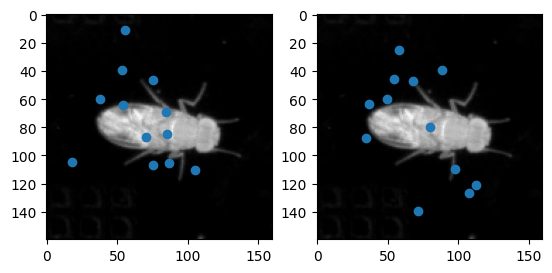

In [ ]:
# from matplotlib import pyplot as plt

# fig, (ax1, ax2) = plt.subplots(1, 2, frameon=False)
# ax1.imshow(X[0].cpu().permute(1, 2, 0).numpy(), cmap="gray")
# ax2.imshow(X[0].cpu().permute(1, 2, 0).numpy(), cmap="gray")
# ax1.scatter(all_y_preds[0][:, 0], all_y_preds[0][:, 1])
# ax2.scatter(all_y_gt[0][:, 0], all_y_gt[0][:, 1])

In [ ]:
xv, yv = make_grid_vectors(
    image_height=160,
    image_width=160,
    output_stride=2
)

# Get all y_preds and y_gt.
all_y_preds, all_y_gt = [], []
_ = model.eval()
for x in val_dl:
  peaks = inference(model, device, X, xv, yv)
  peaks = clip_peaks(peaks)

  all_y_preds.append(peaks)

  out_of_bounds = np.where(np.all(np.isclose(gt_kp.cpu().numpy(), 0), axis=1))[0].tolist()
  gt_kp[out_of_bounds, :] = np.nan
  all_y_gt.append(gt_kp)

all_y_preds = np.concatenate(all_y_preds, axis=0)
all_y_gt = np.concatenate(all_y_gt, axis=0)

# Define thresholds.
match_score_thresholds = np.linspace(0.5, 0.95, 10)
recall_thresholds = np.linspace(0, 1, 101)

# Get evaluation metrics.
match_scores = get_match_scores(all_y_preds, all_y_gt)
precisions, AP, mAP, mAR = evaluate(match_scores, 400, 0, recall_thresholds, match_score_thresholds)

In [ ]:
mAP

0.7393531379546477

In [ ]:
precisions

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.985     , 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.83028721, ..., 0.        , 0.        ,
        0.        ],
       [0.57142857, 0.57142857, 0.30769231, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])